<a href="https://colab.research.google.com/github/gchenkabam/Spoon-Knife/blob/main/kabam_Ligheweight_mmm_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [ ]:
# installs lightweight_mmm
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google/lightweight_mmm.git to /tmp/pip-req-build-wznszk3x
  Running command git clone -q https://github.com/google/lightweight_mmm.git /tmp/pip-req-build-wznszk3x


In [ ]:
# NOTE: current version of mmm only suport plot functionality based on matplotlib 3.13
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.3.4
Uninstalling matplotlib-3.3.4:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.4-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.4.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.3.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 12.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

# Package import

In [ ]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

In [ ]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro
import numpy as np

import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Data ingestion and transformation


TEST FOR version control

In [ ]:
SEED = 105
N_CHAINS = 2

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
%load_ext google.colab.data_table

Authenticated


In [ ]:
# Connect to BQ to pull raw dataset
%%bigquery --project sparx-ua df_mcoc_agg_data
SELECT
date AS install_date,
channel AS media_source,
SUM(spend) AS spend,
SUM(adn_impressions) AS impressions,
SUM(adn_installs) AS installs

FROM `sparx-ua.dbt_view.af_spend_retrospective`
WHERE game_id = 'mcoc'
AND date >= '2020-01-01'
AND channel IN ('Facebook', 'Google Adwords', 'Apple Search Ads', 'Vungle', 'AdColony')
GROUP BY 1, 2
ORDER BY 1

In [ ]:
# Check the shape of original results from SQL
print(df_mcoc_agg_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3408 entries, 0 to 3407
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   install_date  3408 non-null   object 
 1   media_source  3408 non-null   object 
 2   spend         3234 non-null   float64
 3   impressions   3385 non-null   float64
 4   installs      3225 non-null   float64
dtypes: float64(3), object(2)
memory usage: 133.2+ KB
None


In [ ]:
# Preparing the data
df_mcoc_agg_data_pivot = df_mcoc_agg_data.set_index(['install_date', 'media_source']) #set structured index for data pivot
media_data_raw = df_mcoc_agg_data_pivot['impressions'].unstack().fillna(0) # get impressions per media source per day
costs_raw = df_mcoc_agg_data_pivot['spend'].unstack().reset_index().sum(axis = 0) # get total cost per media source
installs_raw = df_mcoc_agg_data_pivot['installs'].groupby('install_date').sum() # get installs as target KPI per day

# Check dataset shape or schema
print(f"media_data_raw shape is: {media_data_raw.shape}")
print(f"costs_raw shape is: {costs_raw.shape}")
print(f"Installs_raw shape is: {installs_raw.shape}")


media_data_raw shape is: (721, 5)
costs_raw shape is: (5,)
Installs_raw shape is: (721,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


In [ ]:
# Dataset split for model training purpose
split_point = pd.Timestamp('2021-01-30')
# Media data
media_data_train = media_data_raw.loc[:split_point - pd.Timedelta(1, 'D')]
media_data_test = media_data_raw.loc[split_point:]
# target
target_train = installs_raw.loc[:split_point - pd.Timedelta(1, 'D')]
target_test = installs_raw.loc[split_point:]


/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:1601: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return arr.searchsorted(value, side=side, sorter=sorter)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:3361: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.get_loc(casted_key)


In [ ]:
# Transform pandas dataframe to numpy before data scaling
media_data_train_np = media_data_train.to_numpy()
target_train_np = target_train.to_numpy()
costs_np = costs_raw.to_numpy()
media_data_test_np = media_data_test.to_numpy()

media_data_train_jax = jnp.array(media_data_train_np)
target_train_jax = jnp.array(target_train_np)
costs_jax = jnp.array(costs_np)
media_data_test_jax = jnp.array(media_data_test_np)


# Scaling the data
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train_jax)
target_train = target_scaler.fit_transform(target_train_jax)
costs = cost_scaler.fit_transform(costs_jax)

## Training the model

In [ ]:
# Training the model

mmm = lightweight_mmm.LightweightMMM(model_name = 'carryover')

number_samples = 200
number_samples = 200

In [ ]:
# Model fit
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    number_warmup=number_samples,
    number_samples=number_samples,
    number_chains=N_CHAINS,
    seed=SEED
)

/usr/local/lib/python3.7/dist-packages/lightweight_mmm/lightweight_mmm.py:256: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  num_chains=number_chains)
sample: 100%|██████████| 400/400 [03:49<00:00,  1.74it/s, 1023 steps of size 1.18e-03. acc. prob=0.93]


In [ ]:
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.47      0.21      0.43      0.21      0.99    139.46      1.02
ad_effect_retention_rate[1]      0.61      0.25      0.72      0.13      0.93      3.66      1.24
ad_effect_retention_rate[2]      0.39      0.18      0.39      0.01      0.63    364.46      1.00
ad_effect_retention_rate[3]      0.18      0.17      0.24      0.00      0.37      1.01     11.23
ad_effect_retention_rate[4]      0.33      0.23      0.50      0.01      0.57      1.10      3.05
              coef_media[0]      0.07      0.04      0.08      0.00      0.11      1.17      2.45
              coef_media[1]      0.03      0.02      0.03      0.00      0.05      1.19      2.68
              coef_media[2]      0.22      0.10      0.19      0.08      0.37      3.53      1.18
              coef_media[3]      0.63      0.25      0.57      0.35      0.93      1.03      5.81
              coef_

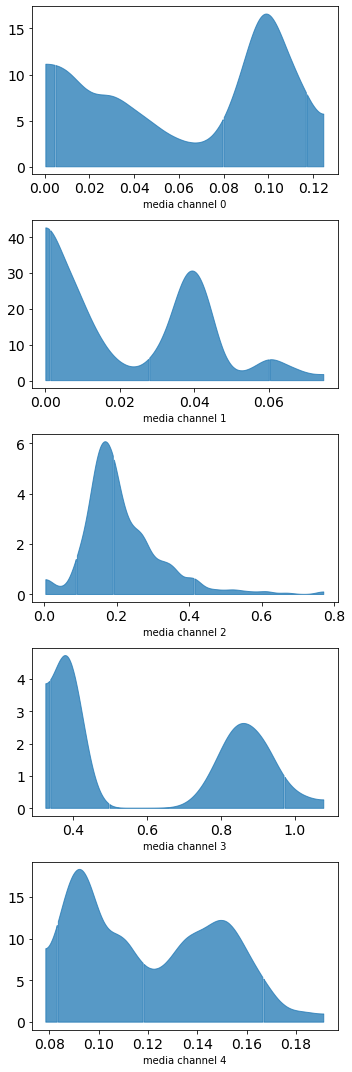

In [ ]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)

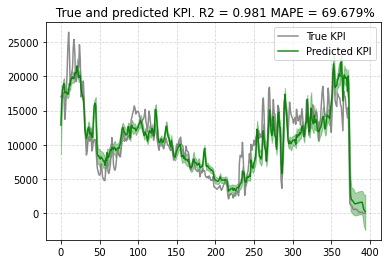

In [ ]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [ ]:
new_predictions = mmm.predict(
    media=media_scaler.transform(media_data_test_jax),
    seed=SEED
)
new_predictions.shape

(400, 326)

In [ ]:
target_test_np = target_test.to_numpy()
target_test_jax = jnp.array(target_test_np)

print(type(target_test_jax))
target_test_jax.shape

<class 'jaxlib.xla_extension.DeviceArray'>


(326,)

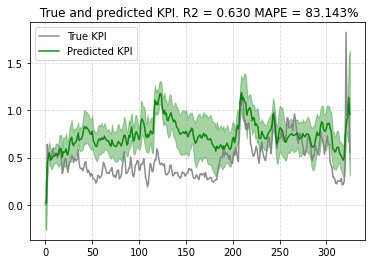

In [ ]:
plot.plot_out_of_sample_model_fit(
    out_of_sample_predictions=new_predictions,
    out_of_sample_target=target_scaler.transform(target_test_jax)
    )

## Media Insights

In [ ]:
# Media insights
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

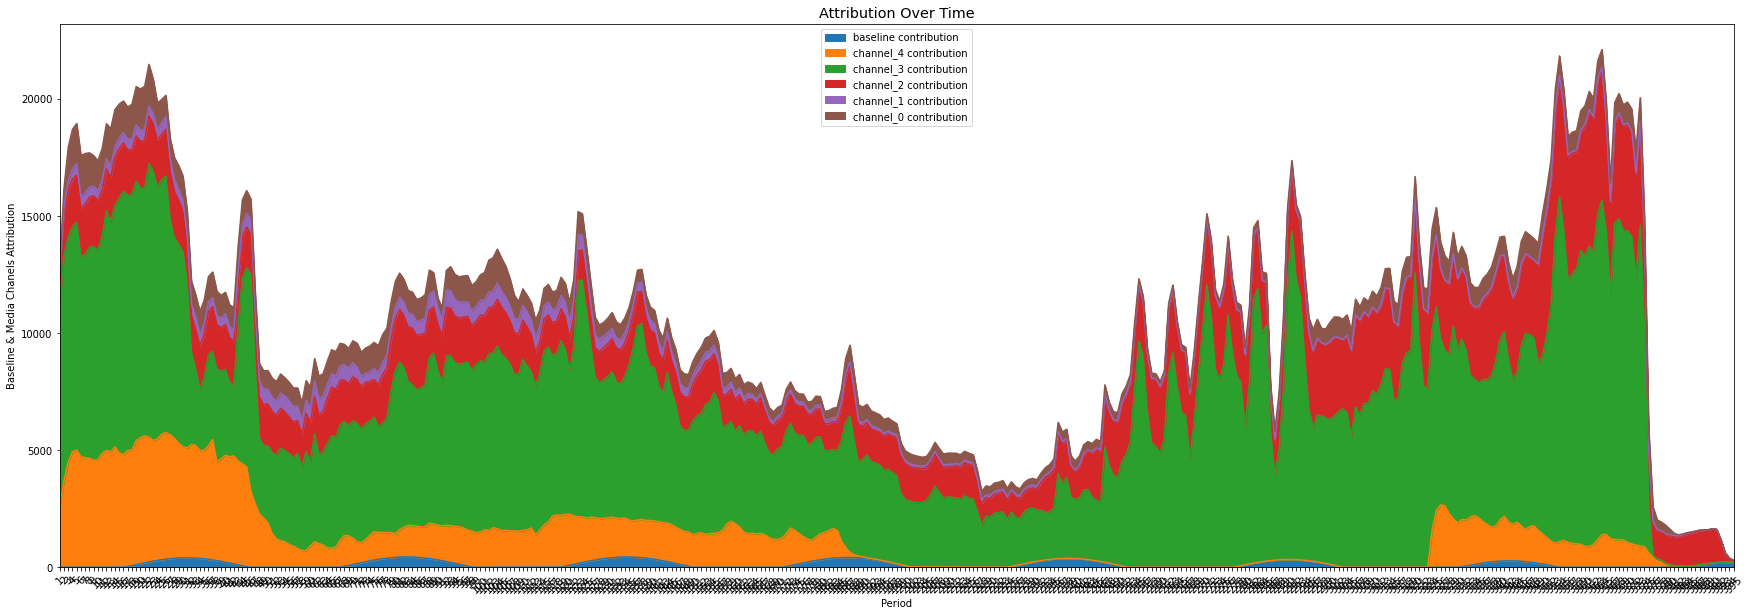

In [ ]:
plot.plot_media_baseline_contribution_area_plot(
    media_mix_model=mmm,
    target_scaler=target_scaler,
    fig_size=(30,10)
)

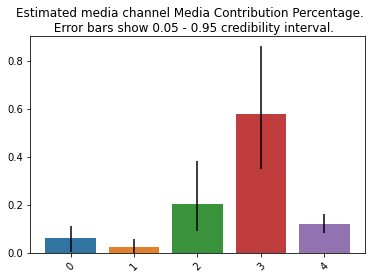

In [ ]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")

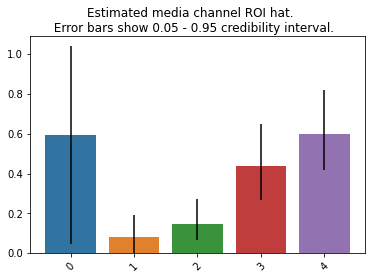

In [ ]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")

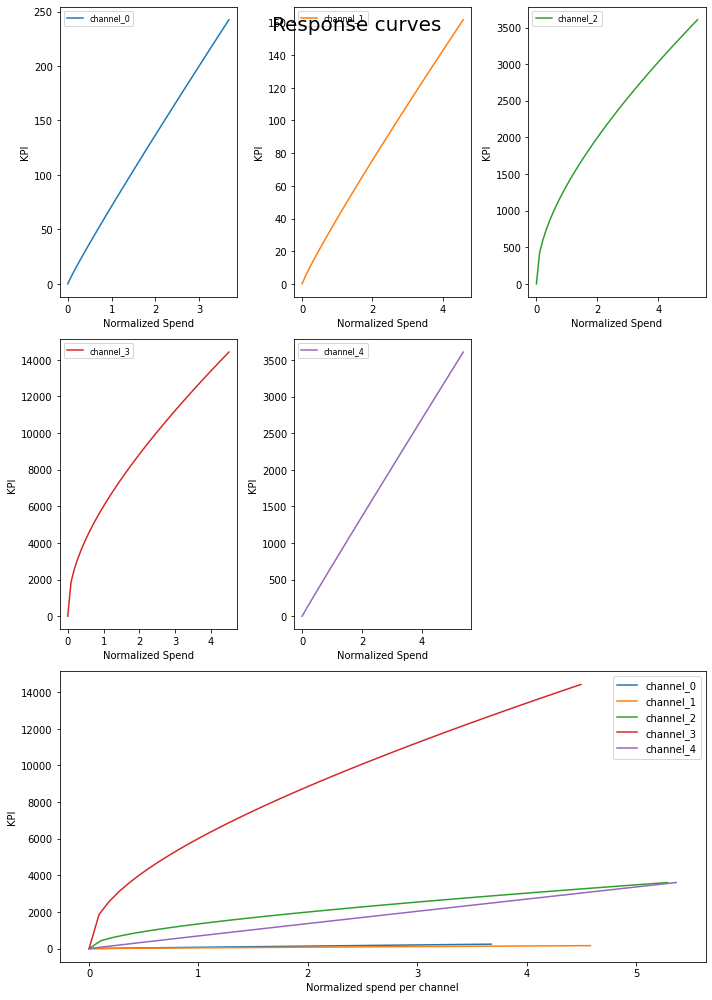

In [ ]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

# Optimization

In [ ]:
# prices = jnp.ones(mmm.n_media_channels)
# media_data_raw_jax = jnp.array(media_data_raw.astype(np.float32))

# print(media_data_raw_jax.dtype)
# print(type(prices))
# print(type(media_data_raw_jax))


float32
<class 'jaxlib.xla_extension.DeviceArray'>
<class 'jaxlib.xla_extension.DeviceArray'>


In [ ]:
# n_time_periods = 10
# budget = jnp.sum(jnp.dot(prices, media_data_raw.mean(axis=0)))* n_time_periods

TypeError: ignored